In [1]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
from datetime import datetime
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
pd.options.display.max_columns=None

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier 
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import plot_importance

from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

from sklearn.inspection import PartialDependenceDisplay

# Data Loading

In [2]:
def load_pickle_file(file_path):
    try:
        with open(file_path, 'rb') as file:
            data = pickle.load(file)  
        return data  
    except (pickle.UnpicklingError, EOFError, AttributeError, TypeError):
        return False  
    except Exception as e:
        return False  

In [3]:
def read_cleaned_data(cleaned_data_path):
    path = Path(cleaned_data_path)
    assert path.exists(), "Data file does not exist"
    data = load_pickle_file(cleaned_data_path)
    if data is not False:
        return data
    else :
        print("Error reading pickle file")
        return False

# Data Preparation

In [4]:
'''
prep_config = {
    numeric_cols_to_standardize:[],
    cat_cols_to_encode:[],
    target_variable:'<var_name>',
    test_split_size:
}

'''
def prepare_data(full_data_with_labels,prep_config, folder):
    assert full_data_with_labels.shape > (0,0) , "Error, dataset is empty"
    
    #Identifying rows where atleast 1 sale information is available    
    data_with_labels = full_data_with_labels.iloc[np.where((full_data_with_labels.Sale_MF+full_data_with_labels.Sale_CC+full_data_with_labels.Sale_CL)>0)[0],].copy()
    
    # Step 1 :  Encode categorical variables
    if len(prep_config["cat_cols_to_encode"]) > 0:
        assert set(prep_config["cat_cols_to_encode"]).issubset(set(data_with_labels.columns)), "Categorical columns are not in the dataset"
        data_encoded = pd.get_dummies(data_with_labels, columns=prep_config['cat_cols_to_encode'])
    
    # Step 2 :  Split into training and test set
    dependent_variable = prep_config['target_variable']
    #print("dependent variable :",set({dependent_variable}))
    
    
    
    ## Drop unnecessary columns
    cols_to_drop = set(['Sale_MF', 'Sale_CC', 'Sale_CL','Revenue_MF', 'Revenue_CC', 'Revenue_CL', 'Client']) - set({dependent_variable})  
    
    '''print("columns to drop : ",list(cols_to_drop))
    print("data_encoded columns : ",data_encoded.columns)
    print(cols_to_drop in list(data_encoded.columns))'''
    
    data_encoded.drop(columns=list(cols_to_drop),inplace=True)
    
    assert set({dependent_variable}).issubset(set(data_encoded.columns)), "Target variable provided not in the dataset"
    
    independent_variables = list(set(data_encoded.columns)-set({dependent_variable}))

    try:
        X_train, X_test, y_train, y_test = train_test_split(data_encoded[independent_variables], data_encoded[dependent_variable], test_size=prep_config['test_split_size'], random_state=50, stratify=data_encoded[dependent_variable])
   
    except ValueError as e:
        print(f"ValueError: {e}")
    except Exception as e:
        print(f"Unexpected error: {e}")
    
   
    # Step 3 : Data normalization
    scaler = StandardScaler()
    try:
        X_train[prep_config['numeric_cols_to_standardize']] = scaler.fit_transform(X_train[prep_config['numeric_cols_to_standardize']])
        X_test[prep_config['numeric_cols_to_standardize']] = scaler.transform(X_test[prep_config['numeric_cols_to_standardize']])
        with open(folder+'/'+'scaler.pkl','wb') as f:
            pickle.dump(scaler,f)
    except Exception as e:
        print(f"Unexpected error: {e}")

    
    return X_train,X_test,y_train,y_test

# Oversampling to handle unbalanced data

In [5]:
def sanity_check_oversampled_data(X_oversampled, y_oversampled, X_org,y_org):
    print("X_oversampled ",X_oversampled.shape)
    display(X_oversampled.head())
    print("y_oversampled ",len(y_oversampled))
    print("X_org ",X_org.shape)
    display(X_org.head())
    print("y_org ",len(y_org))
    X_train_majority = X_org[y_org==0]
    print("X_train_majority ",X_train_majority.shape)
    
    assert X_oversampled.shape[0] ==  X_train_majority.shape[0] * 2, "Sanity check failed"
    assert len(y_oversampled) ==  X_train_majority.shape[0] * 2, "Sanity check failed"
    assert y_oversampled.describe()['50%'] == 0.5, "Sanity check failed"

    return 1

In [6]:
# Oversampling can take two values 'random' or 'SMOTE'
def oversample(X_train, y_train,oversampling_method):
    assert oversampling_method in ['Random','SMOTE'], "Oversampling can take two values 'random' or 'SMOTE'"
    if oversampling_method == 'Random':
        X_train_majority = X_train[y_train==0]
        X_train_minority = X_train[y_train==1]
        df_minority_oversampled = resample(X_train_minority, 
                                   replace=True,     # Sample with replacement
                                   n_samples=X_train_majority.shape[0],  # Match majority class size
                                   random_state=50)
        X_train_oversampled = pd.concat([X_train_majority, df_minority_oversampled])
        y_train_oversampled = pd.concat([pd.Series([0]*X_train_majority.shape[0]),pd.Series([1]*df_minority_oversampled.shape[0])])
        if sanity_check_oversampled_data(X_train_oversampled,y_train_oversampled,X_train, y_train):
            return X_train_oversampled, y_train_oversampled
        else:
            print("Error in oversampled data")
            return None
    else:
        smote = SMOTE(sampling_strategy='auto', random_state=50)
        X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)
        return X_train_oversampled, y_train_oversampled
        
        

# Model training

In [7]:
def plot_confusion_matrix(cm):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred No Sale", "Pred Sale"], yticklabels=["Actual No Sale", "Actual Sale"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

In [8]:
def run_test_data_results(model,x_test,y_test,folder,model_type):
    '''numeric_cols_to_standardize=['Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder']

    with open(folder+'/'+'scaler.pkl','rb') as f:
        scaler = pickle.load(f)
    x_test_scaled = x_test.copy()
    x_test_scaled[numeric_cols_to_standardize] = scaler.transform(x_test[numeric_cols_to_standardize])
    y_pred = model.predict(x_test_scaled)'''
    
    y_pred = model.predict(x_test)
    
    # run classification report and confusion matrix
    report = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    print("Classification Report:\n" )
    print(tabulate(df_report, headers='keys', tablefmt='pretty'))
    df_report.to_csv(folder+'/'+'classification_report.csv')
    
    print("Confusion matrix:\n" )
    plot_confusion_matrix(confusion_matrix(y_test, y_pred))    
    
    # identify feature importance
    
    if model_type == 'xgboost':
        booster = model.get_booster()
        f_imp = booster.get_score(importance_type="weight")
        importance_df = pd.DataFrame(f_imp.items(), columns=['Feature', 'Importance'])
        importance_df = importance_df.sort_values(by='Importance', ascending=False)
        importance_df.to_csv(folder+'/'+'feature_importance.csv')
        plot_importance(model)
        plt.show()
    elif model_type in ['logreg','svm']:
        feature_importance = model.coef_[0] if model_type == 'logreg' else model.coef_.flatten()
        normalized_importance = abs(feature_importance) / sum(abs(feature_importance))
        df_imp = pd.DataFrame(list(normalized_importance),columns=['normalized_importance'])
        df_imp['Feature'] = list(x_test.columns)
        df_imp.sort_values(by='normalized_importance',ascending=False)
        df_imp.to_csv(folder+'/'+'feature_importance.csv')
        display(df_imp)
        plt.bar(x_test.columns, normalized_importance)
        plt.xlabel('Features')
        plt.xticks(rotation=90)
        plt.ylabel('Importance (Normalized Value)')
        plt.title('Feature Importance')
        plt.show()
    
    return(importance_df)
    

## XGBoost 

In [9]:
def train_xgboost_grid_search_with_feature_selection(eval_m,param_grid, grid_search_params,data,folder_to_save_res):
    xgb = XGBClassifier(eval_metric=eval_m, random_state=50)
    grid_search = GridSearchCV(
        estimator=xgb, 
        param_grid=param_grid, 
        scoring=grid_search_params['scoring'],  
        cv=grid_search_params['num_cv'],  
        verbose=1, 
        n_jobs=-1 
    )
    
    X,y = data["X_training_data"],data["y_training_data"]
    target_variable = data["target_variable"]
    
    sfs = SequentialFeatureSelector(xgb, n_features_to_select='auto',scoring='roc_auc', direction='forward', cv=5)
    sfs.fit(X, y)
    selected_features = sfs.get_support(indices=True)
    print("Selected feature indices:", selected_features)
    print("Selected features = ",X.columns[selected_features])
    
    X_train_selected = sfs.transform(X)
    
    
    
    start = datetime.now()
    #grid_search.fit(X, y)
    grid_search.fit(X_train_selected, y)
    end = datetime.now()
    print(f"Total time taken for grid search : {end-start}")
    
    file_name = folder_to_save_res+'/'+'grid_search_'+target_variable+'_xgboost.pkl'
    with open(file_name,'wb') as f:
        pickle.dump(grid_search,f)
        
    best_xgb = XGBClassifier(**grid_search.best_params_,  eval_metric=eval_m, random_state=50)
    #best_xgb.fit(X, y)
    best_xgb.fit(X_train_selected, y)
    file_name = folder_to_save_res+'/'+target_variable+'_xgboost_model.json'
    best_xgb.save_model(file_name)
    
    file_name = folder_to_save_res+'/'+'features_selected.txt'
    with open(file_name,'w') as f:
        f.write(str(X.columns[selected_features])) 
    
    print("**************** RESULTS OF GRID SEARCH *********************") 
    print("Best Parameters:", grid_search.best_params_)
    print("Best Accuracy:", grid_search.best_score_)
    
    print("---------------- TEST DATA RESUTS ---------------------------")
    x_test,y_test = data["X_test_data"],data["y_test_data"]
    X_test_selected = sfs.transform(x_test)
    #X_test_selected = pd.DataFrame(columns=list(X.columns[selected_features]))
    run_test_data_results(best_xgb,X_test_selected,y_test,folder_to_save_res,'xgboost')

In [10]:
'''
param_grid = {
    'n_estimators': [100, 200,300],  # Number of boosting rounds
    'max_depth': [3, 5, 7,10],  # Maximum depth of trees
    'learning_rate': [0.005,0.01, 0.1, 0.2],  # Step size shrinkage
    'subsample': [0.8, 1.0],  # Fraction of samples used per tree
    'colsample_bytree': [0.8, 1.0],  # Fraction of features used per tree
    'scale_pos_weight' : [scaling, scaling/2,4]
}
grid_search_params={
    'scoring':'roc_auc',
    'num_cv':2
}
data_grid_search={
    "X_training_data":X_train,
    "y_training_data":y_train,
    "X_test_data":X_test,
    "y_test_data":y_test,
    "target_variable":"Sale_MF"
}
'''
def train_xgboost_grid_search(eval_m,param_grid, grid_search_params,data,folder_to_save_res):
    xgb = XGBClassifier(eval_metric=eval_m, random_state=50)
    grid_search = GridSearchCV(
        estimator=xgb, 
        param_grid=param_grid, 
        scoring=grid_search_params['scoring'],  
        cv=StratifiedKFold(n_splits=grid_search_params['num_cv']),  
        verbose=1, 
        n_jobs=-1 
    )
    
    X,y = data["X_training_data"],data["y_training_data"]
    target_variable = data["target_variable"]

    start = datetime.now()
    grid_search.fit(X, y)
    end = datetime.now()
    print(f"Total time taken for grid search : {end-start}")
    
    file_name = folder_to_save_res+'/'+'grid_search_'+target_variable+'_xgboost.pkl'
    with open(file_name,'wb') as f:
        pickle.dump(grid_search,f)
        
    best_xgb = XGBClassifier(**grid_search.best_params_,  eval_metric=eval_m, random_state=50)
    best_xgb.fit(X, y)
    
    file_name = folder_to_save_res+'/'+target_variable+'_xgboost_model.json'
    best_xgb.save_model(file_name)

    print("**************** RESULTS OF GRID SEARCH *********************") 
    print("Best Parameters:", grid_search.best_params_)
    print("Best Accuracy:", grid_search.best_score_)
    
    print("---------------- TEST DATA RESUTS ---------------------------")
    x_test,y_test = data["X_test_data"],data["y_test_data"]
    feature_imp = run_test_data_results(best_xgb,x_test,y_test,folder_to_save_res,'xgboost')
    
    top_5_features = feature_imp.head(5)
    top_5_features = list(top_5_features['Feature'])

   
    
    return best_xgb

## Logistic Regression

In [11]:
def train_logreg_grid_search_with_feature_selection(param_grid, grid_search_params,data_grid_search,folder_to_save_res,class_weights="balanced"):
    if class_weights=="NA":
        logreg = LogisticRegression(random_state=50) 
    else:
        logreg = LogisticRegression(class_weight=class_weights,random_state=50) 
    grid_search = GridSearchCV(
        estimator=logreg, 
        param_grid=param_grid, 
        scoring=grid_search_params['scoring'],  
        cv=StratifiedKFold(n_splits=grid_search_params['num_cv']),  
        verbose=1, 
        n_jobs=-1 
    )
    
    X,y = data_grid_search["X_training_data"],data_grid_search["y_training_data"]
    target_variable = data_grid_search["target_variable"]
    
    
    sfs = SequentialFeatureSelector(logreg, n_features_to_select='auto',scoring='roc_auc', direction='forward', cv=5)
    sfs.fit(X, y)
    selected_features = sfs.get_support(indices=True)
    print("Selected feature indices:", selected_features)
    print("Selected features = ",X.columns[selected_features])
    X_train_selected = sfs.transform(X)
    
    start = datetime.now()
    grid_search.fit(X_train_selected, y)
    end = datetime.now()
    print(f"Total time taken for grid search : {end-start}")
    print("folder_to_save_res : ",folder_to_save_res)
    
    file_name = folder_to_save_res+'/'+'grid_search_'+target_variable+'_logreg.pkl'
    with open(file_name,'wb') as f:
        pickle.dump(grid_search,f)
    best_model = grid_search.best_estimator_
    file_name = folder_to_save_res+'/'+target_variable+'_logreg.pkl'
    with open(file_name,'wb') as f:
        pickle.dump(best_model,f)
        
    print("**************** RESULTS OF GRID SEARCH *********************") 
    print("Best Parameters:", grid_search.best_params_)
    print("Best Accuracy:", grid_search.best_score_)
    
    print("---------------- TEST DATA RESUTS ---------------------------")
    x_test,y_test = data_grid_search["X_test_data"],data_grid_search["y_test_data"]
    X_test_selected = sfs.transform(x_test)
    run_test_data_results(best_model,X_test_selected,y_test,folder_to_save_res,'logreg')

In [12]:
'''
param_grid = {
    "penalty": ["l1", "l2"],
    "solver":['liblinear','saga'],
    "C" : [0.1,2.0,5,10],
    "max_iter":[100,200,300],
}
'''
#def train_logreg_grid_search(param_grid, grid_scoring, grid_cv,X,y,x_test,target_variable,folder_to_save_res,class_weights="balanced"):
def train_logreg_grid_search(param_grid, grid_search_params,data_grid_search,folder_to_save_res,class_weights="balanced"):
    if class_weights=="NA":
        logreg = LogisticRegression(random_state=50) 
    else:
        logreg = LogisticRegression(class_weight=class_weights,random_state=50) 
    grid_search = GridSearchCV(
        estimator=logreg, 
        param_grid=param_grid, 
        scoring=grid_search_params['scoring'],  
        cv=StratifiedKFold(n_splits=grid_search_params['num_cv']),  
        verbose=1, 
        n_jobs=-1 
    )
    
    X,y = data_grid_search["X_training_data"],data_grid_search["y_training_data"]
    target_variable = data_grid_search["target_variable"]
    
    start = datetime.now()
    grid_search.fit(X, y)
    end = datetime.now()
    print(f"Total time taken for grid search : {end-start}")
    print("folder_to_save_res : ",folder_to_save_res)
    
    file_name = folder_to_save_res+'/'+'grid_search_'+target_variable+'_logreg.pkl'
    with open(file_name,'wb') as f:
        pickle.dump(grid_search,f)
    best_model = grid_search.best_estimator_
    file_name = folder_to_save_res+'/'+target_variable+'_logreg.pkl'
    with open(file_name,'wb') as f:
        pickle.dump(best_model,f)
        
    print("**************** RESULTS OF GRID SEARCH *********************") 
    print("Best Parameters:", grid_search.best_params_)
    print("Best Accuracy:", grid_search.best_score_)
    
    print("---------------- TEST DATA RESUTS ---------------------------")
    x_test,y_test = data_grid_search["X_test_data"],data_grid_search["y_test_data"]
    run_test_data_results(best_model,x_test,y_test,folder_to_save_res,'logreg')
    return best_model

## SVM

In [13]:
'''
param_grid = {
    'C': [0.1, 1, 10],               
    'kernel': ['linear', 'rbf'],     
    'gamma': ['scale', 'auto'],       
    'degree': [3, 4],         
}
'''
#def train_svm_grid_search(param_grid, grid_scoring, grid_cv,X,y,x_test,target_variable,folder_to_save_res,class_weights="balanced"):
def train_svm_grid_search(param_grid, grid_search_params,data_grid_search,folder_to_save_res,class_weights="balanced"):
    if class_weights=="NA":
        svm = SVC(random_state=50,probability=True)
    else:
        svm = SVC(class_weight=class_weights,random_state=50,probability=True)
    grid_search = GridSearchCV(
        estimator=svm, 
        param_grid=param_grid, 
        scoring=grid_search_params['scoring'], 
        cv=StratifiedKFold(n_splits=grid_search_params['num_cv']), 
        verbose=1, 
        n_jobs=-1
    )
    
    X,y = data_grid_search["X_training_data"],data_grid_search["y_training_data"]
    target_variable = data_grid_search["target_variable"] 

    start = datetime.now()
    grid_search.fit(X, y)
    end = datetime.now()
    print(f"Total time taken for grid search : {end-start}")
  
   
    file_name = folder_to_save_res+'/'+'grid_search_'+target_variable+'_svm.pkl'
    with open(file_name,'wb') as f:
        pickle.dump(grid_search,f)
        
    print("Best Parameters:", grid_search.best_params_)
    print("Best Accuracy:", grid_search.best_score_)
    best_model = grid_search.best_estimator_
    file_name = folder_to_save_res+'/'+target_variable+'_svm.pkl'
    with open(file_name,'wb') as f:
        pickle.dump(best_model,f)

       
    print("**************** RESULTS OF GRID SEARCH *********************") 
    print("Best Parameters:", grid_search.best_params_)
    print("Best Accuracy:", grid_search.best_score_)
    
    
    print("---------------- TEST DATA RESUTS ---------------------------")
    x_test,y_test = data_grid_search["X_test_data"],data_grid_search["y_test_data"]

    run_test_data_results(best_model,x_test,y_test,folder_to_save_res,'svm')
    return best_model

# Model Runs

In [18]:
'''
model_run_config = {
    "data_prep_config":prep_config,
    "model_type":'xgboost', # Can only be one of 'xgboost','logreg','svm'
    "use_oversampling":True,
    "oversampling_method":"<NA,Random,SMOTE>",
    "xgboost_eval_m":"<NA,'auc'>",
    "grid_search_params":<dictionary containing 'scoring' and 'num_cv'>
    "class_weights:<class weights if required for logreg or svm else NA"
}

prep_config = {
    "numeric_cols_to_standardize":['Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder'],
    "cat_cols_to_encode":['Sex'],
    "target_variable":'Sale_MF',
    "test_split_size": 0.2
}


'''
def train_model(model_run_config):
    folder_add = './models/stratified/'+str(datetime.now()).replace(" ","_").replace(":","_").replace(".","_")
    print("folder address : ",folder_add)
    folder_path = Path(folder_add)
    folder_path.mkdir(parents=True, exist_ok=True)
    with open(folder_add+'/model_config.txt', 'w') as f:
            json.dump(model_run_config, f, indent=4)
    f.close()
    
    cleaned_data = read_cleaned_data("./data/cleaned/data_for_modeling.pkl")
    cleaned_data.drop(columns=['VolumeCred_CA','TransactionsCred_CA','VolumeDeb_CA','TransactionsDeb_CA'],inplace=True)
    # Prepare data
    X_train,X_test,y_train,y_test = prepare_data(cleaned_data, model_run_config["data_prep_config"],folder_add)
    
    # Checkif oversampling required
    if model_run_config['oversampling_method'] != "NA":
        x_over,y_over = oversample(X_train, y_train,oversampling_method=model_run_config['oversampling_method'])
    else:
        x_over, y_over = X_train, y_train
    # Check target variable 
    target_var = model_run_config["data_prep_config"]["target_variable"]
    
    data_grid_search={
        "X_training_data":x_over,
        "y_training_data":y_over,
        "X_test_data":X_test,
        "y_test_data":y_test,
        "target_variable":target_var
    }
    
    # Check model type
    model_type = model_run_config["model_type"]
    
    if model_type == 'xgboost':
        t= train_xgboost_grid_search(model_run_config["xgboost_eval_m"],model_run_config["param_grid"], model_run_config["grid_search_params"], data_grid_search,folder_add)
        #train_xgboost_grid_search_with_feature_selection(model_run_config["xgboost_eval_m"],model_run_config["param_grid"], model_run_config["grid_search_params"], data_grid_search,folder_add)
    elif model_type == 'logreg':
        print("folder_add = ",folder_add)
        t = train_logreg_grid_search(model_run_config["param_grid"], model_run_config["grid_search_params"],data_grid_search,folder_add,model_run_config["class_weights"])
        #train_logreg_grid_search_with_feature_selection(model_run_config["param_grid"], model_run_config["grid_search_params"],data_grid_search,folder_add,model_run_config["class_weights"])
    elif model_type == 'svm':
        t = train_svm_grid_search(model_run_config["param_grid"], model_run_config["grid_search_params"],data_grid_search,folder_add,model_run_config["class_weights"])
     

In [15]:
def train_ensemble_model(model_run_config):
    folder_add = './models'+'ensemble_'+str(datetime.now()).replace(" ","_").replace(":","_").replace(".","_")
    print("folder address : ",folder_add)
    folder_path = Path(folder_add)
    folder_path.mkdir(parents=True, exist_ok=True)
    with open(folder_add+'/model_config.txt', 'w') as f:
            json.dump(model_run_config, f, indent=4)
    f.close()
    
    cleaned_data = read_cleaned_data("./data/cleaned/data_for_modeling.pkl")
    cleaned_data.drop(columns=['VolumeCred_CA','TransactionsCred_CA','VolumeDeb_CA','TransactionsDeb_CA'],inplace=True)
    # Prepare data
    X_train,X_test,y_train,y_test = prepare_data(cleaned_data, model_run_config["data_prep_config"],folder_add)
    
    
    # Check target variable 
    target_var = model_run_config["data_prep_config"]["target_variable"]
    
    data_grid_search={
        "X_training_data":X_train,
        "y_training_data":y_train,
        "X_test_data":X_test,
        "y_test_data":y_test,
        "target_variable":target_var
    }
    

    m_xgboost = train_xgboost_grid_search(model_run_config["xgboost_eval_m"],model_run_config["param_grid"]["xgboost"], model_run_config["grid_search_params"], data_grid_search,folder_add)
    m_logreg = train_logreg_grid_search(model_run_config["param_grid"]["logreg"], model_run_config["grid_search_params"],data_grid_search,folder_add,model_run_config["class_weights"])
    #m_svm = train_svm_grid_search(model_run_config["param_grid"]["svm"], model_run_config["grid_search_params"],data_grid_search,folder_add,model_run_config["class_weights"])
     
    prob_xgboost_train = m_xgboost.predict_proba(X_train)[:,1]
    prob_logreg_train = m_logreg.predict_proba(X_train)[:,1]
    #prob_svm_train = m_svm.predict_proba(X_train)[:,1]
    
    
    prob_xgboost_test = m_xgboost.predict_proba(X_test)[:,1]
    prob_logreg_test = m_logreg.predict_proba(X_test)[:,1]
    #prob_svm_test = m_svm.predict_proba(X_test)[:,1]
    
    '''def weighted_ensemble(weights, log_probs, xgb_probs, svm_probs):
        w1, w2, w3 = weights
        return (w1 * log_probs) + (w2 * xgb_probs) + (w3 * svm_probs)'''
    def weighted_ensemble(weights, log_probs, xgb_probs):
        w1, w2 = weights
        return (w1 * log_probs) + (w2 * xgb_probs) 

    # Function to optimize (maximize AUC)
    '''def evaluate_weights(weights):
        ensemble_probs = weighted_ensemble(weights, prob_logreg_train, prob_xgboost_train, prob_svm_train)
        return -roc_auc_score(y_train, ensemble_probs)  # Negative because GridSearch minimizes'''
    
    def evaluate_weights(weights):
        ensemble_probs = weighted_ensemble(weights, prob_logreg_train, prob_xgboost_train)
        return -roc_auc_score(y_train, ensemble_probs)  # Negative because GridSearch minimizes
    
    # Define parameter grid
    '''param_grid = {'weights': [(w1, w2, w3) for w1 in np.linspace(0, 1, 5) 
                                              for w2 in np.linspace(0, 1, 5) 
                                              for w3 in np.linspace(0, 1, 5) if w1 + w2 + w3 == 1]}'''
    param_grid = {'weights': [(w1, w2) for w1 in np.linspace(0, 1, 5) 
                                              for w2 in np.linspace(0, 1, 5) 
                                              if w1 + w2 == 1]}

    # Perform grid search with cross-validation
    '''grid_search = GridSearchCV(estimator=VotingClassifier(
        estimators=[('log_reg', m_logreg), ('xgb', m_xgboost), ('svm', m_svm)], voting='soft'),
        param_grid=param_grid,
        scoring='roc_auc',
        cv=StratifiedKFold(n_splits=5))'''
    grid_search = GridSearchCV(estimator=VotingClassifier(
        estimators=[('log_reg', m_logreg), ('xgb', m_xgboost)], voting='soft'),
        param_grid=param_grid,
        scoring='roc_auc',
        cv=StratifiedKFold(n_splits=5))
    
    grid_search.fit(X_train, y_train)  # Now done correctly on training set

    # Evaluate best model on test set
    best_weights = grid_search.best_params_['weights']
    
    print("ENSEMBLE WEIGHTS = ",best_weights)
    
    '''ensemble_test_probs = weighted_ensemble(best_weights, prob_logreg_test, prob_xgboost_test, prob_svm_test)'''
    ensemble_test_probs = weighted_ensemble(best_weights, prob_logreg_test, prob_xgboost_test)
    #final_auc = roc_auc_score(y_test, ensemble_test_probs)
    
    '''func = lambda a,b,c:max(a,b,c)
    prob_ensemble = [func(p1[1],p2[1],p3[1]) for p1,p2,p3 in zip(prob_xgboost,prob_logreg,prob_svm)]'''
    
    func = lambda a: 1 if a>0.5 else 0
    y_pred = [func(item) for item in ensemble_test_probs]
    y_pred = np.array(y_pred)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    print("ENSEMBLE PREDICTION Classification Report:\n" )
    print(tabulate(df_report, headers='keys', tablefmt='pretty'))
    df_report.to_csv(folder_add+'/'+'classification_report.csv')
    
    print("ENSEMBLE PREDICTION Confusion matrix:\n" )
    plot_confusion_matrix(confusion_matrix(y_test, y_pred))    
    

Target variable =  Sale_CC
(############################################)
folder address :  ./models/stratified/2025-03-24_20_43_39_138331
X_oversampled  (410, 26)


,ActBal_MF,VolumeCred,TransactionsDeb_PaymentOrder,ActBal_SA,TransactionsDebCashless_Card,VolumeDeb,Count_OVD,VolumeDebCash_Card,Count_CC,ActBal_CC,Count_CA,Count_SA,TransactionsDeb,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,Age,TransactionsDebCash_Card,Sex_F,ActBal_CL,Count_CL,Count_MF,Tenure,ActBal_CA,TransactionsCred,ActBal_OVD,Sex_M
927,-0.208101,-0.383665,-0.878077,-0.348975,0.451754,0.098215,-0.607332,1.928831,-0.336650,-0.199689,-0.250376,-0.470764,-0.122774,-0.097595,-0.701094,-0.840539,0.233845,0,-0.228696,-0.296246,-0.179349,1.114826,-0.495011,-0.415892,-0.227724,1
832,-0.208101,-0.083728,-0.656065,-0.348975,1.565760,-0.339248,1.646545,-0.435647,-0.336650,-0.199689,2.846867,-0.470764,1.386671,0.236922,-0.481743,-0.730896,0.550057,0,-0.228696,-0.296246,-0.179349,0.217232,-0.349607,1.383858,-0.227724,1
336,-0.208101,-0.111055,-0.212041,-0.348975,0.823089,0.408639,-0.607332,0.526548,-0.336650,-0.199689,-0.250376,-0.470764,0.506161,0.050059,0.969793,-1.005003,0.550057,1,-0.228696,-0.296246,-0.179349,0.037713,-0.641632,-0.579506,-0.227724,0
863,-0.208101,2.089291,2.896124,-0.348975,0.204197,2.459021,1.646545,0.634416,-0.336650,-0.199689,-0.250376,-0.470764,3.147691,0.194967,1.535038,1.461957,1.182480,0,1.300133,2.795817,-0.179349,1.025067,-0.643856,5.146973,-0.227724,1
246,7.294654,0.874462,3.562160,-0.348975,2.555987,2.246575,1.646545,0.170583,2.970443,3.507733,-0.250376,-0.470764,4.405563,3.167158,1.628741,0.201066,1.182480,1,-0.228696,-0.296246,0.007847,-1.323638,-0.642229,4.165291,-0.227724,0


y_oversampled  410
X_org  (334, 26)


,ActBal_MF,VolumeCred,TransactionsDeb_PaymentOrder,ActBal_SA,TransactionsDebCashless_Card,VolumeDeb,Count_OVD,VolumeDebCash_Card,Count_CC,ActBal_CC,Count_CA,Count_SA,TransactionsDeb,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,Age,TransactionsDebCash_Card,Sex_F,ActBal_CL,Count_CL,Count_MF,Tenure,ActBal_CA,TransactionsCred,ActBal_OVD,Sex_M
927,-0.208101,-0.383665,-0.878077,-0.348975,0.451754,0.098215,-0.607332,1.928831,-0.33665,-0.199689,-0.250376,-0.470764,-0.122774,-0.097595,-0.701094,-0.840539,0.233845,0,-0.228696,-0.296246,-0.179349,1.114826,-0.495011,-0.415892,-0.227724,1
215,-0.208101,-0.082896,0.231982,-0.348975,0.080419,-0.062429,1.646545,-0.034366,-0.33665,-0.199689,-0.250376,-0.470764,-0.059881,0.066817,0.079717,1.187850,-0.398578,0,-0.228696,-0.296246,0.195042,-0.844921,-0.405874,-0.579506,0.222583,1
832,-0.208101,-0.083728,-0.656065,-0.348975,1.565760,-0.339248,1.646545,-0.435647,-0.33665,-0.199689,2.846867,-0.470764,1.386671,0.236922,-0.481743,-0.730896,0.550057,0,-0.228696,-0.296246,-0.179349,0.217232,-0.349607,1.383858,-0.227724,1
336,-0.208101,-0.111055,-0.212041,-0.348975,0.823089,0.408639,-0.607332,0.526548,-0.33665,-0.199689,-0.250376,-0.470764,0.506161,0.050059,0.969793,-1.005003,0.550057,1,-0.228696,-0.296246,-0.179349,0.037713,-0.641632,-0.579506,-0.227724,0
863,-0.208101,2.089291,2.896124,-0.348975,0.204197,2.459021,1.646545,0.634416,-0.33665,-0.199689,-0.250376,-0.470764,3.147691,0.194967,1.535038,1.461957,1.182480,0,1.300133,2.795817,-0.179349,1.025067,-0.643856,5.146973,-0.227724,1


y_org  334
X_train_majority  (205, 26)
Fitting 5 folds for each of 192 candidates, totalling 960 fits
Total time taken for grid search : 0:00:50.597483
**************** RESULTS OF GRID SEARCH *********************
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'scale_pos_weight': 4.5, 'subsample': 0.8}
Best Accuracy: 0.8848304580606783
---------------- TEST DATA RESUTS ---------------------------
Classification Report:

+--------------+---------------------+--------------------+---------------------+--------------------+
|              |      precision      |       recall       |      f1-score       |      support       |
+--------------+---------------------+--------------------+---------------------+--------------------+
|      0       | 0.6428571428571429  | 0.6923076923076923 | 0.6666666666666666  |        52.0        |
|      1       | 0.42857142857142855 |       0.375        | 0.39999999999999997 |        32.0        |
|   a

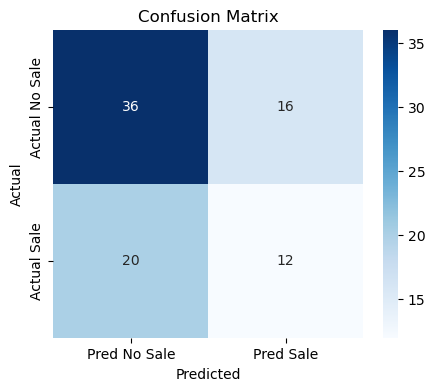

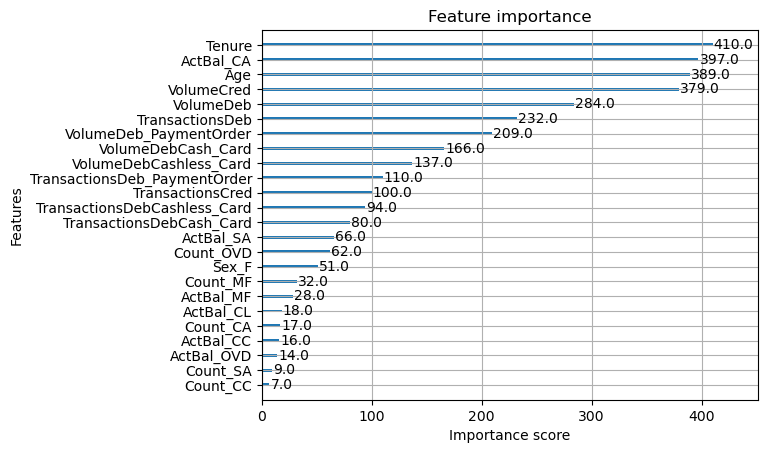

In [19]:
prep_config = {
    "numeric_cols_to_standardize":['Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred',
       'TransactionsCred', 'VolumeDeb', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb','TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder'],
    "cat_cols_to_encode":['Sex'],
    "target_variable":'Sale_CC',
    "test_split_size": 0.2
}

grid_params = {
    'scoring':'roc_auc',
    'num_cv':5
}


param_grid_xgboost = {
    'n_estimators': [100, 200,300],  # Number of boosting rounds
    'max_depth': [3, 5, 7,10],  # Maximum depth of trees
    'learning_rate': [0.005,0.01, 0.1, 0.2],  # Step size shrinkage
    'subsample': [0.8, 1.0],  # Fraction of samples used per tree
    'colsample_bytree': [0.8, 1.0],  # Fraction of features used per tree
    'scale_pos_weight' : [4]
}
model_run_config_xgboost1 = {
    "data_prep_config":prep_config,
    "model_type":'xgboost', 
    "oversampling_method":'Random',
    "xgboost_eval_m":'auc',
    "param_grid":param_grid_xgboost,
    "grid_search_params":grid_params,
    "class_weights":"NA"
}

#target_columns = ['Sale_MF','Sale_CC','Sale_CL']
target_columns = ['Sale_CC']
scaling = {'Sale_MF':5,'Sale_CC':4.5,'Sale_CL':3.4}
testing_done=[]
for col in target_columns:
    print("Target variable = ",col)
    prep_config['target_variable'] = col
    param_grid_xgboost['scale_pos_weight'] =  [scaling[col]]
    configs_to_run = [model_run_config_xgboost1]
    
    for cfg in configs_to_run:
        testing_done.append([(col,cfg)])
        print("(############################################)")
        train_model(cfg)

prep_config = {
    "numeric_cols_to_standardize":['Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder'],
    "cat_cols_to_encode":['Sex'],
    "target_variable":'Sale_CC',
    "test_split_size": 0.2
}

grid_params = {
    'scoring':'roc_auc',
    'num_cv':5
}

param_grid_logreg = {
    "penalty": ["l1", "l2"],
    "solver":['liblinear','saga'],
    "C" : [0.05,0.1,2.0,5,10],
    "max_iter":[100,200,300],
}
model_run_config_logreg1 = {
    "data_prep_config":prep_config,
    "model_type":'logreg', 
    "oversampling_method":'SMOTE',
    "xgboost_eval_m":'auc',
    "param_grid":param_grid_logreg,
    "grid_search_params":grid_params,
    "class_weights":"balanced"
}
model_run_config_logreg2 = {
    "data_prep_config":prep_config,
    "model_type":'logreg', 
    "oversampling_method":'Random',
    "xgboost_eval_m":'auc',
    "param_grid":param_grid_logreg,
    "grid_search_params":grid_params,
    "class_weights":"balanced"
}
model_run_config_logreg3 = {
    "data_prep_config":prep_config,
    "model_type":'logreg', 
    "oversampling_method":"NA",
    "xgboost_eval_m":'auc',
    "param_grid":param_grid_logreg,
    "grid_search_params":grid_params,
    "class_weights":"balanced"
}
param_grid_svm = {
    'C': [0.05,0.1, 1, 10],                
    'kernel': ['linear'],      
    'gamma': ['scale', 'auto']
}

model_run_config_svm1 = {
    "data_prep_config":prep_config,
    "model_type":'svm', 
    "oversampling_method":'SMOTE',
    "xgboost_eval_m":'auc',
    "param_grid":param_grid_svm,
    "grid_search_params":grid_params,
    "class_weights":"balanced"
}

model_run_config_svm2 = {
    "data_prep_config":prep_config,
    "model_type":'svm', 
    "oversampling_method":"NA",
    "xgboost_eval_m":'auc',
    "param_grid":param_grid_svm,
    "grid_search_params":grid_params,
    "class_weights":"balanced"
}
model_run_config_svm3 = {
    "data_prep_config":prep_config,
    "model_type":'svm', 
    "oversampling_method":'Random',
    "xgboost_eval_m":'auc',
    "param_grid":param_grid_svm,
    "grid_search_params":grid_params,
    "class_weights":"balanced"
}
param_grid_xgboost = {
    'n_estimators': [100, 200,300],  # Number of boosting rounds
    'max_depth': [3, 5, 7,10],  # Maximum depth of trees
    'learning_rate': [0.005,0.01, 0.1, 0.2],  # Step size shrinkage
    'subsample': [0.8, 1.0],  # Fraction of samples used per tree
    'colsample_bytree': [0.8, 1.0],  # Fraction of features used per tree
    'scale_pos_weight' : [4]
}
model_run_config_xgboost1 = {
    "data_prep_config":prep_config,
    "model_type":'xgboost', 
    "oversampling_method":'Random',
    "xgboost_eval_m":'auc',
    "param_grid":param_grid_xgboost,
    "grid_search_params":grid_params,
    "class_weights":"NA"
}
model_run_config_xgboost2 = {
    "data_prep_config":prep_config,
    "model_type":'xgboost', 
    "oversampling_method":'SMOTE',
    "xgboost_eval_m":'auc',
    "param_grid":param_grid_xgboost,
    "grid_search_params":grid_params,
    "class_weights":"NA"
}
model_run_config_xgboost3 = {
    "data_prep_config":prep_config,
    "model_type":'xgboost', 
    "oversampling_method":"NA",
    "xgboost_eval_m":'auc',
    "param_grid":param_grid_xgboost,
    "grid_search_params":grid_params,
    "class_weights":"NA"
}

target_columns = ['Sale_MF','Sale_CC','Sale_CL']
scaling = {'Sale_MF':0.35,'Sale_CC':0.4,'Sale_CL':0.5}
testing_done=[]
for col in target_columns:
    prep_config['target_variable'] = col
    param_grid_xgboost['scale_pos_weight'] =  [1/scaling[col]]
    configs_to_run = [model_run_config_logreg1, model_run_config_logreg2,model_run_config_logreg3, model_run_config_svm1, model_run_config_svm2, model_run_config_svm3, model_run_config_xgboost1, model_run_config_xgboost2,model_run_config_xgboost3]
    #configs_to_run = [model_run_config_logreg1, model_run_config_svm1, model_run_config_xgboost1]
    
    for cfg in configs_to_run:
        testing_done.append([(col,cfg)])
        print("($$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$)")
        print("testing done = ",testing_done)
        train_model(cfg)
